# ***Task 4 Facial Emotion Recognition***



Uploaded kaggle.json to authenticate with Kaggle API and fetched the FER-2013 dataset.

Extracted and organized images into training, validation, and test folders.

In [2]:
# ================================
# Facial Emotion Recognition - FER2013
# ================================

# Step 1. Setup
!pip install kaggle -q

# Upload your kaggle.json file (from Kaggle account > API > Create New Token)
from google.colab import files
files.upload()

# Make kaggle directory & move kaggle.json
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download FER-2013 dataset
!kaggle datasets download -d msambare/fer2013
!unzip fer2013.zip -d fer2013_data

Streaming output truncated to the last 5000 lines.
  inflating: fer2013_data/train/sad/Training_65242339.jpg  
  inflating: fer2013_data/train/sad/Training_65267116.jpg  
  inflating: fer2013_data/train/sad/Training_65275626.jpg  
  inflating: fer2013_data/train/sad/Training_6529266.jpg  
  inflating: fer2013_data/train/sad/Training_65329617.jpg  
  inflating: fer2013_data/train/sad/Training_65338712.jpg  
  inflating: fer2013_data/train/sad/Training_65338797.jpg  
  inflating: fer2013_data/train/sad/Training_65387162.jpg  
  inflating: fer2013_data/train/sad/Training_65404494.jpg  
  inflating: fer2013_data/train/sad/Training_65426218.jpg  
  inflating: fer2013_data/train/sad/Training_65430136.jpg  
  inflating: fer2013_data/train/sad/Training_65437377.jpg  
  inflating: fer2013_data/train/sad/Training_6545735.jpg  
  inflating: fer2013_data/train/sad/Training_65463385.jpg  
  inflating: fer2013_data/train/sad/Training_65473985.jpg  
  inflating: fer2013_data/train/sad/Training_655028

Loaded dataset from directories using ImageDataGenerator.

Split into train (22,968), validation (5,741), and test (7,178) images across 7 classes.

In [5]:
# ================================
# Step 2. Imports & Preprocessing
# ================================
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Paths to your dataset
train_dir = "fer2013_data/train"
test_dir  = "fer2013_data/test"

# Data preprocessing & augmentation
datagen = ImageDataGenerator(
    rescale=1./255,       # normalize pixels to [0,1]
    validation_split=0.2, # reserve 20% of training for validation
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True
)

# Training generator
train_gen = datagen.flow_from_directory(
    train_dir,
    target_size=(48,48),
    color_mode="grayscale",
    batch_size=64,
    class_mode="categorical",
    subset="training"
)

# Validation generator
val_gen = datagen.flow_from_directory(
    train_dir,
    target_size=(48,48),
    color_mode="grayscale",
    batch_size=64,
    class_mode="categorical",
    subset="validation"
)

# Test generator (no augmentation, only rescaling)
test_datagen = ImageDataGenerator(rescale=1./255)
test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size=(48,48),
    color_mode="grayscale",
    batch_size=64,
    class_mode="categorical",
    shuffle=False
)

print("Train batches:", len(train_gen))
print("Validation batches:", len(val_gen))
print("Test batches:", len(test_gen))


Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
Train batches: 359
Validation batches: 90
Test batches: 113


Built a Sequential CNN with Conv2D, BatchNorm, MaxPooling, Dense, and Dropout layers.

Final layer outputs probabilities for 7 emotion classes using softmax.

In [6]:
# ================================
# Step 3. CNN Model
# ================================
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

model = Sequential([
    Conv2D(32, (3,3), activation='relu', input_shape=(48,48,1)),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(7, activation='softmax')  # match dataset: 7 emotions
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 46, 46, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 46, 46, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 21, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 21, 21, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 356,743 (1.36 MB)

 Trainable params: 356,295 (1.36 MB)

 Non-trainable params: 448 (1.75 KB)

Applied data augmentation (rotation, zoom, flips) with ImageDataGenerator.

Trained the CNN with early stopping and model checkpointing for best weights.


In [7]:
# ================================
# Step 4. Training
# ================================
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint("best_model.h5", save_best_only=True)

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30,
    callbacks=[early_stop, checkpoint]
)


Epoch 1/30


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


358/359 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.2327 - loss: 2.0239

359/359 ━━━━━━━━━━━━━━━━━━━━ 32s 68ms/step - accuracy: 0.2329 - loss: 2.0229 - val_accuracy: 0.2393 - val_loss: 1.8672
Epoch 2/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.3230 - loss: 1.7065

359/359 ━━━━━━━━━━━━━━━━━━━━ 18s 51ms/step - accuracy: 0.3230 - loss: 1.7064 - val_accuracy: 0.3665 - val_loss: 1.6253
Epoch 3/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 19s 53ms/step - accuracy: 0.3657 - loss: 1.6165 - val_accuracy: 0.3003 - val_loss: 1.6928
Epoch 4/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.3975 - loss: 1.5498

359/359 ━━━━━━━━━━━━━━━━━━━━ 18s 51ms/step - accuracy: 0.3975 - loss: 1.5497 - val_accuracy: 0.4198 - val_loss: 1.4759
Epoch 5/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 19s 54ms/step - accuracy: 0.4150 - loss: 1.5035 - val_accuracy: 0.3985 - val_loss: 1.5575
Epoch 6/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 18s 51ms/step - accuracy: 0.4243 - loss: 1.4747 - val_accuracy: 0.4245 - val_loss: 1.5010
Epoch 7/30
358/359 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.4497 - loss: 1.4200

359/359 ━━━━━━━━━━━━━━━━━━━━ 20s 57ms/step - accuracy: 0.4497 - loss: 1.4200 - val_accuracy: 0.4520 - val_loss: 1.4354
Epoch 8/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.4593 - loss: 1.4026

359/359 ━━━━━━━━━━━━━━━━━━━━ 18s 51ms/step - accuracy: 0.4593 - loss: 1.4026 - val_accuracy: 0.4778 - val_loss: 1.3692
Epoch 9/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4714 - loss: 1.3973

359/359 ━━━━━━━━━━━━━━━━━━━━ 19s 54ms/step - accuracy: 0.4714 - loss: 1.3972 - val_accuracy: 0.4754 - val_loss: 1.3614
Epoch 10/30
358/359 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.4839 - loss: 1.3546

359/359 ━━━━━━━━━━━━━━━━━━━━ 19s 52ms/step - accuracy: 0.4839 - loss: 1.3546 - val_accuracy: 0.4940 - val_loss: 1.3304
Epoch 11/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 19s 52ms/step - accuracy: 0.4877 - loss: 1.3344 - val_accuracy: 0.4626 - val_loss: 1.4269
Epoch 12/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 20s 56ms/step - accuracy: 0.4921 - loss: 1.3302 - val_accuracy: 0.4478 - val_loss: 1.3983
Epoch 13/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 20s 56ms/step - accuracy: 0.4991 - loss: 1.3120 - val_accuracy: 0.4748 - val_loss: 1.3703
Epoch 14/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 19s 53ms/step - accuracy: 0.5062 - loss: 1.2931 - val_accuracy: 0.4433 - val_loss: 1.4599
Epoch 15/30
359/359 ━━━━━━━━━━━━━━━━━━━━ 18s 51ms/step - accuracy: 0.5069 - loss: 1.2884 - val_accuracy: 0.4466 - val_loss: 1.4238


Evaluated model on test set to measure accuracy and loss.

Plotted training vs validation curves for both accuracy and loss.

113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.4064 - loss: 1.4365
Test Accuracy: 0.5175536274909973


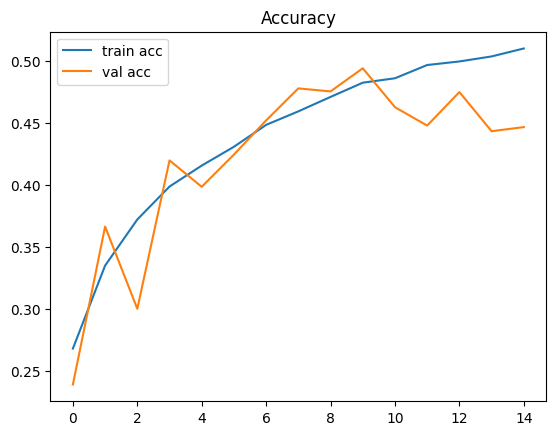

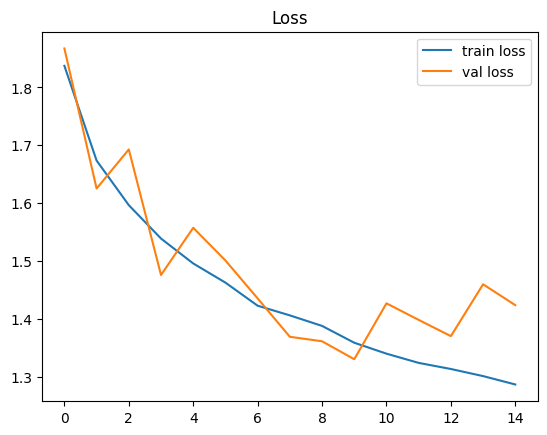

In [9]:
# ================================
# Step 5. Evaluation
# ================================
import matplotlib.pyplot as plt

# Evaluate on test set
test_loss, test_acc = model.evaluate(test_gen)
print("Test Accuracy:", test_acc)

# Plot accuracy & loss curves
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.title("Accuracy")
plt.show()

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.title("Loss")
plt.show()


Tested the model on unseen samples from test set.

Displayed true vs predicted labels with the image for all 7 emotions.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
True Label: Angry
Predicted: Angry


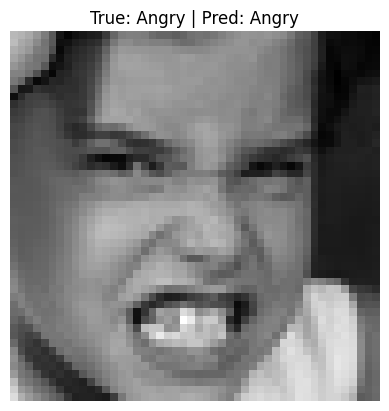

In [21]:
# ================================
# Step 6. Inference Example (7 emotions)
# ================================
import numpy as np
import matplotlib.pyplot as plt

# Match your dataset class order
emotion_labels = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]

# Get one batch from test_gen
x_batch, y_batch = next(test_gen)

# Pick one sample
sample_img = x_batch[0]
sample_true = y_batch[0]

# Predict
pred = model.predict(sample_img.reshape(1,48,48,1))
pred_label = emotion_labels[np.argmax(pred)]
true_label = emotion_labels[np.argmax(sample_true)]

print("True Label:", true_label)
print("Predicted:", pred_label)

# Show image
plt.imshow(sample_img.reshape(48,48), cmap="gray")
plt.title(f"True: {true_label} | Pred: {pred_label}")
plt.axis("off")
plt.show()
